# For an analysis competition...
What to predict?
- age ... too few nans (prediction may be meaningless...)
- cancellation of premium membership

# Libraries

In [1]:
# basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import time
import datetime
import os
import sys
import pickle
from tqdm import tqdm_notebook as tqdm

# custom modeling functions
mypath = os.getcwd()
sys.path.append(mypath + '/models/') 
from base_models import BaseModel
from lgb_models import LgbModel
from catb_models import CatbModel

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
import plotly.figure_factory as ff
import plotly.express as px
import missingno as msno

sns.set_context("talk")
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
style.use('fivethirtyeight')

# custom EDA functions
mypath = os.getcwd()
sys.path.append(mypath + '/code/') 
from utils import reduce_mem_usage, plot_target
from categorical_encoder import label_encoding
from feature_converter import categorize_features
from adversarial_validaton import AdversarialValidation
from catplot import CategoricalVisualizer
from denseplot import DenseVisualizer
from nn_utils import Mish, LayerNormalization, CyclicLR
from permutation_importance import PermulationImportance

# stats
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error, log_loss
from sklearn.model_selection import train_test_split
import scipy as sp
from functools import partial
from collections import Counter

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

print("libraries imported")

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


libraries imported


# Load data

In [2]:
!ls

EDA.ipynb            catboost_info        models
EDA_houseprice.ipynb code                 nn_laputa.ipynb
EDA_laputa.ipynb     gbdt_laputa.ipynb
EDA_titanic.ipynb    inputs


In [3]:
# check path
datapath = "inputs/"
datapath = "/Volumes/sec/anemos-poc-large-sec/users/kakawagu/data/laputa_comp"
files = os.listdir(datapath)
print(files)

['laputa_age.csv', '.DS_Store', 'figs', 'laputa.csv', 'laputa_noage.csv']


In [4]:
# import data
time0 = time.time()

train = pd.read_csv(datapath + '/laputa_age.csv', index_col=0)
test = pd.read_csv(datapath + '/laputa_noage.csv', index_col=0)

time1 = time.time()
print(time1 - time0, " seconds to load data")

28.790058135986328  seconds to load data


In [5]:
# check train
print(train.shape)
train.head()

(10000, 815)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,2_user_profile_master_commerce_registration_month,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,0012356A351358D871,1,NaN,20190428,20190501.0,20191201,49,8,31,8,...,NaN,0.067452,NaN,NaN,NaN,NaN,0.05795,NaN,NaN,NaN
1,00148ED6D273F9B2DD,1,NaN,20160925,20160929.0,20191127,45,39,166,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0003BCA15E2EFB1955,1,NaN,20160508,20160513.0,20191130,23,43,186,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000A7D82545E783A8E,1,NaN,20160612,20160615.0,20191201,42,42,181,42,...,NaN,0.035689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000A84CEFE8881F2AA,1,NaN,20191020,20191022.0,20191201,58,2,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# check test
print(test.shape)
test.head()

(10000, 815)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,2_user_profile_master_commerce_registration_month,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,0013CB9311A8ADDE2C,0,NaN,20170528,20170530.0,20191201,NaN,31,131,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039645C6FA1C0ABC,0,NaN,20190224,20190301.0,20191201,NaN,10,40,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00151F8DE7DFD5D93C,0,NaN,20190623,20190627.0,20191201,NaN,6,23,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000C53CB2E2051E6A2,0,NaN,20190616,20190620.0,20191201,NaN,6,24,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0012E6705A765C2DA2,0,NaN,20190922,20190923.0,20191201,NaN,3,10,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Target

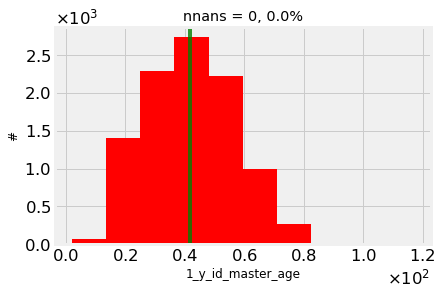

In [7]:
# hist
target = "1_y_id_master_age"
plot_target(train, target, objective="regression")

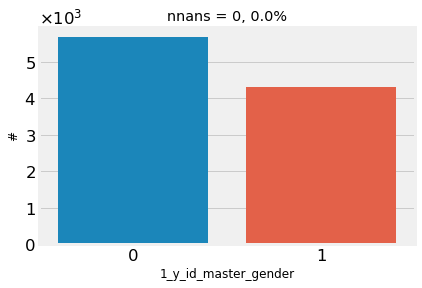

In [8]:
# hist
target = "1_y_id_master_gender"
plot_target(train, target, objective="classification")

In [9]:
# binarize gender
train["1_y_id_master_gender"] -= 1
train.loc[train["1_y_id_master_gender"] < 0, "1_y_id_master_gender"] = 0

# multi-task
target = ["1_y_id_master_age", "1_y_id_master_gender"]

# Dense features

In [10]:
dense_features = ['1_y_id_master_registration_date', '1_y_id_master_first_update', '1_y_id_master_last_update', '1_y_id_master_registration_month', '1_y_id_master_registration_week', '2_user_profile_master_commerce_registration_month', '2_user_profile_master_commerce_age', '2_user_profile_master_commerce_shopping_order_count', '2_user_profile_master_commerce_auction_won_count', '2_user_profile_master_commerce_auction_bid_aid_count', '2_user_profile_master_commerce_auction_submit_count', '2_user_profile_master_commerce_auction_sold_count', '2_user_profile_master_commerce_earned_point_count', '2_user_profile_master_commerce_monthly_fixed_point', '2_user_profile_master_commerce_used_point_count', '2_user_profile_master_commerce_used_point', '2_user_profile_master_commerce_invalid_ypoint', '3_points_monthly_summary_interim_point_y', '3_points_monthly_summary_fixed_point_y', '3_points_monthly_summary_fixed_point_t', '4_point_user_balance_master_interim_point_y', '4_point_user_balance_master_fixed_point_y', '4_point_user_balance_master_fixed_point_t', '8_app_user_monthly_stats_toppage_activate_day', '8_app_user_monthly_stats_weather_activate_day', '8_app_user_monthly_stats_transit_activate_day', '8_app_user_monthly_stats_shopping_activate_day', '8_app_user_monthly_stats_gyao_activate_day', '8_app_user_monthly_stats_auctions_activate_day', '8_app_user_monthly_stats_mail_activate_day', '8_app_user_monthly_stats_yjtrend_activate_day', '8_app_user_monthly_stats_apppkgcal_activate_day', '8_app_user_monthly_stats_ymail_activate_day', '8_app_user_monthly_stats_ysmarttool_activate_day', '8_app_user_monthly_stats_ynaviapp_activate_day', '8_app_user_monthly_stats_maps_activate_day', '8_app_user_monthly_stats_sportsnavi_activate_day', '8_app_user_monthly_stats_ymobile_activate_day', '8_app_user_monthly_stats_ysmartsecurity_activate_day', '8_app_user_monthly_stats_yjcal_activate_day', '8_app_user_monthly_stats_yfiler_activate_day', '8_app_user_monthly_stats_finance_activate_day', '8_app_user_monthly_stats_ebookjapan_activate_day', '8_app_user_monthly_stats_toppage_activate_count', '8_app_user_monthly_stats_weather_activate_count', '8_app_user_monthly_stats_transit_activate_count', '8_app_user_monthly_stats_shopping_activate_count', '8_app_user_monthly_stats_gyao_activate_count', '8_app_user_monthly_stats_auctions_activate_count', '8_app_user_monthly_stats_mail_activate_count', '8_app_user_monthly_stats_yjtrend_activate_count', '8_app_user_monthly_stats_apppkgcal_activate_count', '8_app_user_monthly_stats_ymail_activate_count', '8_app_user_monthly_stats_emg_activate_count', '8_app_user_monthly_stats_ysmarttool_activate_count', '8_app_user_monthly_stats_ynaviapp_activate_count', '8_app_user_monthly_stats_maps_activate_count', '8_app_user_monthly_stats_sportsnavi_activate_count', '8_app_user_monthly_stats_ymobile_activate_count', '8_app_user_monthly_stats_ysmartsecurity_activate_count', '8_app_user_monthly_stats_yjcal_activate_count', '8_app_user_monthly_stats_yfiler_activate_count', '8_app_user_monthly_stats_finance_activate_count', '8_app_user_monthly_stats_ybackup_activate_count', '8_app_user_monthly_stats_chiebukuro_activate_count', '8_app_user_monthly_stats_ebookjapan_activate_count', '8_app_user_monthly_stats_pmall_activate_count', '8_app_user_monthly_stats_ychiebukuro_activate_count', '8_app_user_monthly_stats_toppage_duration', '8_app_user_monthly_stats_weather_duration', '8_app_user_monthly_stats_transit_duration', '8_app_user_monthly_stats_shopping_duration', '8_app_user_monthly_stats_gyao_duration', '8_app_user_monthly_stats_auctions_duration', '8_app_user_monthly_stats_mail_duration', '8_app_user_monthly_stats_yjtrend_duration', '8_app_user_monthly_stats_apppkgcal_duration', '8_app_user_monthly_stats_ymail_duration', '8_app_user_monthly_stats_emg_duration', '8_app_user_monthly_stats_ysmarttool_duration', '8_app_user_monthly_stats_ynaviapp_duration', '8_app_user_monthly_stats_maps_duration', '8_app_user_monthly_stats_sportsnavi_duration', '8_app_user_monthly_stats_ymobile_duration', '8_app_user_monthly_stats_ysmartsecurity_duration', '8_app_user_monthly_stats_yjcal_duration', '8_app_user_monthly_stats_yfiler_duration', '8_app_user_monthly_stats_finance_duration', '8_app_user_monthly_stats_ybackup_duration', '8_app_user_monthly_stats_chiebukuro_duration', '8_app_user_monthly_stats_ebookjapan_duration', '8_app_user_monthly_stats_pmall_duration', '8_app_user_monthly_stats_ymsetupman_duration', '8_app_user_monthly_stats_ychiebukuro_duration', '8_app_user_monthly_stats_realestate_duration', '8_app_user_monthly_stats_weather_widget_activate_day']

# Categorical features

In [11]:
cat_features = ['y_id_hex', '1_y_id_master_gender', '2_user_profile_master_commerce_gender', '2_user_profile_master_commerce_generation1', '2_user_profile_master_commerce_generation3', '2_user_profile_master_commerce_generation5', '2_user_profile_master_commerce_premium_user_flag', '2_user_profile_master_commerce_wallet_registered_flag', '2_user_profile_master_commerce_valid_card_count', '2_user_profile_master_commerce_auction_store_flag', '8_app_user_monthly_stats_toppage_flag', '8_app_user_monthly_stats_weather_flag', '8_app_user_monthly_stats_transit_flag', '8_app_user_monthly_stats_shopping_flag', '8_app_user_monthly_stats_gyao_flag', '8_app_user_monthly_stats_auctions_flag', '8_app_user_monthly_stats_mail_flag', '8_app_user_monthly_stats_yjtrend_flag', '8_app_user_monthly_stats_apppkgcal_flag', '8_app_user_monthly_stats_ymail_flag', '8_app_user_monthly_stats_emg_flag', '8_app_user_monthly_stats_ysmarttool_flag', '8_app_user_monthly_stats_ybrowser_flag', '8_app_user_monthly_stats_ynaviapp_flag', '8_app_user_monthly_stats_npb_textlive_flag', '8_app_user_monthly_stats_maps_flag', '8_app_user_monthly_stats_sportsnavi_flag', '8_app_user_monthly_stats_ymobile_flag', '8_app_user_monthly_stats_ysmartsecurity_flag', '8_app_user_monthly_stats_yjcal_flag', '8_app_user_monthly_stats_yfiler_flag', '8_app_user_monthly_stats_apps_map_flag', '8_app_user_monthly_stats_apps_navi_flag', '8_app_user_monthly_stats_finance_flag', '8_app_user_monthly_stats_ybackup_flag', '8_app_user_monthly_stats_chiebukuro_flag', '8_app_user_monthly_stats_yqrcode_flag', '8_app_user_monthly_stats_launcher_buzzhome_flag', '8_app_user_monthly_stats_ebookjapan_flag', '8_app_user_monthly_stats_pmall_flag', '8_app_user_monthly_stats_ymsetupman_flag', '8_app_user_monthly_stats_realtime_buzzalert_flag', '8_app_user_monthly_stats_ychiebukuro_flag', '8_app_user_monthly_stats_ybuzzdetection_flag', '8_app_user_monthly_stats_com_cf_selene_flag', '8_app_user_monthly_stats_realestate_flag', '8_app_user_monthly_stats_minkara_flag', '8_app_user_monthly_stats_com_cf_calendar_flag', '8_app_user_monthly_stats_com_cf_coletto_flag', '8_app_user_monthly_stats_v_assist_flag', '8_app_user_monthly_stats_yfinkeyguardwidget_flag', '8_app_user_monthly_stats_partner_flag', '8_app_user_monthly_stats_com_cfinc_calendar_flag', '8_app_user_monthly_stats_jp_trilltrill_trill_flag', '8_app_user_monthly_stats_yphoto_flag', '8_app_user_monthly_stats_appcover_launcher2_flag', '8_app_user_monthly_stats_com_cfinc_coletto_flag', '8_app_user_monthly_stats_fortune_flag', '8_app_user_monthly_stats_netallica_flag', '8_app_user_monthly_stats_hitouch_flag', '8_app_user_monthly_stats_bookstore_flag', '8_app_user_monthly_stats_voicesearch_flag', '8_app_user_monthly_stats_ybrowser2_flag', '8_app_user_monthly_stats_prem_sports_flag', '8_app_user_monthly_stats_scpro_flag', '8_app_user_monthly_stats_news_tablet_flag', '8_app_user_monthly_stats_wallet_transfer_flag', '8_app_user_monthly_stats_travel_flag', '8_app_user_monthly_stats_timetv_flag', '8_app_user_monthly_stats_passmarket_flag', '8_app_user_monthly_stats_latlonglab_flag', '8_app_user_monthly_stats_yshopping_raku_flag', '8_app_user_monthly_stats_mythingsapp_flag', '8_app_user_monthly_stats_maplocationshare_flag', '8_app_user_monthly_stats_emg_activate_day', '8_app_user_monthly_stats_ybrowser_activate_day', '8_app_user_monthly_stats_npb_textlive_activate_day', '8_app_user_monthly_stats_apps_map_activate_day', '8_app_user_monthly_stats_apps_navi_activate_day', '8_app_user_monthly_stats_ybackup_activate_day', '8_app_user_monthly_stats_chiebukuro_activate_day', '8_app_user_monthly_stats_yqrcode_activate_day', '8_app_user_monthly_stats_launcher_buzzhome_activate_day', '8_app_user_monthly_stats_pmall_activate_day', '8_app_user_monthly_stats_ymsetupman_activate_day', '8_app_user_monthly_stats_realtime_buzzalert_activate_day', '8_app_user_monthly_stats_ychiebukuro_activate_day', '8_app_user_monthly_stats_ybuzzdetection_activate_day', '8_app_user_monthly_stats_com_cf_selene_activate_day', '8_app_user_monthly_stats_realestate_activate_day', '8_app_user_monthly_stats_minkara_activate_day', '8_app_user_monthly_stats_com_cf_calendar_activate_day', '8_app_user_monthly_stats_com_cf_coletto_activate_day', '8_app_user_monthly_stats_v_assist_activate_day', '8_app_user_monthly_stats_yfinkeyguardwidget_activate_day', '8_app_user_monthly_stats_partner_activate_day', '8_app_user_monthly_stats_com_cfinc_calendar_activate_day', '8_app_user_monthly_stats_jp_trilltrill_trill_activate_day', '8_app_user_monthly_stats_yphoto_activate_day', '8_app_user_monthly_stats_appcover_launcher2_activate_day', '8_app_user_monthly_stats_com_cfinc_coletto_activate_day', '8_app_user_monthly_stats_fortune_activate_day', '8_app_user_monthly_stats_netallica_activate_day', '8_app_user_monthly_stats_hitouch_activate_day', '8_app_user_monthly_stats_bookstore_activate_day', '8_app_user_monthly_stats_voicesearch_activate_day', '8_app_user_monthly_stats_ybrowser2_activate_day', '8_app_user_monthly_stats_prem_sports_activate_day', '8_app_user_monthly_stats_scpro_activate_day', '8_app_user_monthly_stats_news_tablet_activate_day', '8_app_user_monthly_stats_wallet_transfer_activate_day', '8_app_user_monthly_stats_travel_activate_day', '8_app_user_monthly_stats_timetv_activate_day', '8_app_user_monthly_stats_passmarket_activate_day', '8_app_user_monthly_stats_latlonglab_activate_day', '8_app_user_monthly_stats_yshopping_raku_activate_day', '8_app_user_monthly_stats_mythingsapp_activate_day', '8_app_user_monthly_stats_maplocationshare_activate_day', '8_app_user_monthly_stats_ybrowser_activate_count', '8_app_user_monthly_stats_npb_textlive_activate_count', '8_app_user_monthly_stats_apps_map_activate_count', '8_app_user_monthly_stats_apps_navi_activate_count', '8_app_user_monthly_stats_yqrcode_activate_count', '8_app_user_monthly_stats_launcher_buzzhome_activate_count', '8_app_user_monthly_stats_ymsetupman_activate_count', '8_app_user_monthly_stats_realtime_buzzalert_activate_count', '8_app_user_monthly_stats_ybuzzdetection_activate_count', '8_app_user_monthly_stats_com_cf_selene_activate_count', '8_app_user_monthly_stats_realestate_activate_count', '8_app_user_monthly_stats_minkara_activate_count', '8_app_user_monthly_stats_com_cf_calendar_activate_count', '8_app_user_monthly_stats_com_cf_coletto_activate_count', '8_app_user_monthly_stats_v_assist_activate_count', '8_app_user_monthly_stats_yfinkeyguardwidget_activate_count', '8_app_user_monthly_stats_partner_activate_count', '8_app_user_monthly_stats_com_cfinc_calendar_activate_count', '8_app_user_monthly_stats_jp_trilltrill_trill_activate_count', '8_app_user_monthly_stats_yphoto_activate_count', '8_app_user_monthly_stats_appcover_launcher2_activate_count', '8_app_user_monthly_stats_com_cfinc_coletto_activate_count', '8_app_user_monthly_stats_fortune_activate_count', '8_app_user_monthly_stats_netallica_activate_count', '8_app_user_monthly_stats_hitouch_activate_count', '8_app_user_monthly_stats_bookstore_activate_count', '8_app_user_monthly_stats_voicesearch_activate_count', '8_app_user_monthly_stats_ybrowser2_activate_count', '8_app_user_monthly_stats_prem_sports_activate_count', '8_app_user_monthly_stats_scpro_activate_count', '8_app_user_monthly_stats_news_tablet_activate_count', '8_app_user_monthly_stats_wallet_transfer_activate_count', '8_app_user_monthly_stats_travel_activate_count', '8_app_user_monthly_stats_timetv_activate_count', '8_app_user_monthly_stats_passmarket_activate_count', '8_app_user_monthly_stats_latlonglab_activate_count', '8_app_user_monthly_stats_yshopping_raku_activate_count', '8_app_user_monthly_stats_mythingsapp_activate_count', '8_app_user_monthly_stats_maplocationshare_activate_count', '8_app_user_monthly_stats_ybrowser_duration', '8_app_user_monthly_stats_npb_textlive_duration', '8_app_user_monthly_stats_apps_map_duration', '8_app_user_monthly_stats_apps_navi_duration', '8_app_user_monthly_stats_yqrcode_duration', '8_app_user_monthly_stats_launcher_buzzhome_duration', '8_app_user_monthly_stats_realtime_buzzalert_duration', '8_app_user_monthly_stats_ybuzzdetection_duration', '8_app_user_monthly_stats_com_cf_selene_duration', '8_app_user_monthly_stats_minkara_duration', '8_app_user_monthly_stats_com_cf_calendar_duration', '8_app_user_monthly_stats_com_cf_coletto_duration', '8_app_user_monthly_stats_v_assist_duration', '8_app_user_monthly_stats_yfinkeyguardwidget_duration', '8_app_user_monthly_stats_partner_duration', '8_app_user_monthly_stats_com_cfinc_calendar_duration', '8_app_user_monthly_stats_jp_trilltrill_trill_duration', '8_app_user_monthly_stats_yphoto_duration', '8_app_user_monthly_stats_appcover_launcher2_duration', '8_app_user_monthly_stats_com_cfinc_coletto_duration', '8_app_user_monthly_stats_fortune_duration', '8_app_user_monthly_stats_netallica_duration', '8_app_user_monthly_stats_hitouch_duration', '8_app_user_monthly_stats_bookstore_duration', '8_app_user_monthly_stats_voicesearch_duration', '8_app_user_monthly_stats_ybrowser2_duration', '8_app_user_monthly_stats_prem_sports_duration', '8_app_user_monthly_stats_scpro_duration', '8_app_user_monthly_stats_news_tablet_duration', '8_app_user_monthly_stats_wallet_transfer_duration', '8_app_user_monthly_stats_travel_duration', '8_app_user_monthly_stats_timetv_duration', '8_app_user_monthly_stats_passmarket_duration', '8_app_user_monthly_stats_latlonglab_duration', '8_app_user_monthly_stats_yshopping_raku_duration', '8_app_user_monthly_stats_mythingsapp_duration', '8_app_user_monthly_stats_maplocationshare_duration', '8_app_user_monthly_stats_toppage_widget_activate_day', '8_app_user_monthly_stats_transit_widget_activate_day', '8_app_user_monthly_stats_shopping_widget_activate_day', '8_app_user_monthly_stats_gyao_widget_activate_day', '8_app_user_monthly_stats_auctions_widget_activate_day', '8_app_user_monthly_stats_mail_widget_activate_day', '8_app_user_monthly_stats_yjtrend_widget_activate_day', '8_app_user_monthly_stats_apppkgcal_widget_activate_day', '8_app_user_monthly_stats_ymail_widget_activate_day', '8_app_user_monthly_stats_emg_widget_activate_day', '8_app_user_monthly_stats_ysmarttool_widget_activate_day', '8_app_user_monthly_stats_ybrowser_widget_activate_day', '8_app_user_monthly_stats_ynaviapp_widget_activate_day', '8_app_user_monthly_stats_npb_textlive_widget_activate_day', '8_app_user_monthly_stats_maps_widget_activate_day', '8_app_user_monthly_stats_sportsnavi_widget_activate_day', '8_app_user_monthly_stats_ymobile_widget_activate_day', '8_app_user_monthly_stats_ysmartsecurity_widget_activate_day', '8_app_user_monthly_stats_yjcal_widget_activate_day', '8_app_user_monthly_stats_yfiler_widget_activate_day', '8_app_user_monthly_stats_apps_map_widget_activate_day', '8_app_user_monthly_stats_apps_navi_widget_activate_day', '8_app_user_monthly_stats_finance_widget_activate_day', '8_app_user_monthly_stats_ybackup_widget_activate_day', '8_app_user_monthly_stats_chiebukuro_widget_activate_day', '8_app_user_monthly_stats_yqrcode_widget_activate_day', '8_app_user_monthly_stats_launcher_buzzhome_widget_activate_day', '8_app_user_monthly_stats_ebookjapan_widget_activate_day', '8_app_user_monthly_stats_pmall_widget_activate_day', '8_app_user_monthly_stats_ymsetupman_widget_activate_day', '8_app_user_monthly_stats_realtime_buzzalert_widget_activate_day', '8_app_user_monthly_stats_ychiebukuro_widget_activate_day', '8_app_user_monthly_stats_ybuzzdetection_widget_activate_day', '8_app_user_monthly_stats_com_cf_selene_widget_activate_day', '8_app_user_monthly_stats_realestate_widget_activate_day', '8_app_user_monthly_stats_minkara_widget_activate_day', '8_app_user_monthly_stats_com_cf_calendar_widget_activate_day', '8_app_user_monthly_stats_com_cf_coletto_widget_activate_day', '8_app_user_monthly_stats_v_assist_widget_activate_day', '8_app_user_monthly_stats_yfinkeyguardwidget_widget_activate_day', '8_app_user_monthly_stats_partner_widget_activate_day', '8_app_user_monthly_stats_com_cfinc_calendar_widget_activate_day', '8_app_user_monthly_stats_jp_trilltrill_trill_widget_activate_day', '8_app_user_monthly_stats_yphoto_widget_activate_day', '8_app_user_monthly_stats_appcover_launcher2_widget_activate_day', '8_app_user_monthly_stats_com_cfinc_coletto_widget_activate_day', '8_app_user_monthly_stats_fortune_widget_activate_day', '8_app_user_monthly_stats_netallica_widget_activate_day', '8_app_user_monthly_stats_hitouch_widget_activate_day', '8_app_user_monthly_stats_bookstore_widget_activate_day', '8_app_user_monthly_stats_voicesearch_widget_activate_day', '8_app_user_monthly_stats_ybrowser2_widget_activate_day', '8_app_user_monthly_stats_prem_sports_widget_activate_day', '8_app_user_monthly_stats_scpro_widget_activate_day', '8_app_user_monthly_stats_news_tablet_widget_activate_day', '8_app_user_monthly_stats_wallet_transfer_widget_activate_day', '8_app_user_monthly_stats_travel_widget_activate_day', '8_app_user_monthly_stats_timetv_widget_activate_day', '8_app_user_monthly_stats_passmarket_widget_activate_day', '8_app_user_monthly_stats_latlonglab_widget_activate_day', '8_app_user_monthly_stats_yshopping_raku_widget_activate_day', '8_app_user_monthly_stats_mythingsapp_widget_activate_day', '8_app_user_monthly_stats_maplocationshare_widget_activate_day']
to_remove = []
for c in cat_features:
    if train[c].nunique() < 2:
        to_remove.append(c)
cat_features = [c for c in cat_features if c not in to_remove]

# Drop leaky columns

In [12]:
# drop leak features
dropcols = ['2_user_profile_master_commerce_age', '2_user_profile_master_commerce_generation1', '2_user_profile_master_commerce_generation3', '2_user_profile_master_commerce_generation5', '2_user_profile_master_commerce_generation7']
dropcols = dropcols + ["1_y_id_master_gender", "2_user_profile_master_commerce_gender"]
group = "y_id_hex"
dropcols = dropcols + target + [group]
dense_features = [f for f in dense_features if f not in dropcols]
cat_features = [f for f in cat_features if f not in dropcols]

# Preprocess for fitting

In [13]:
for f in cat_features:
    if train[f].dtype == "bool":
        train[f] = train[f].astype(int)
        test[f] = test[f].astype(int)
train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

In [14]:
# label encoding object features
train, test, cat_features = label_encoding(train, test, cat_features)
features = cat_features + dense_features
train.head()

,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,2_user_profile_master_commerce_registration_month,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,0012356A351358D871,0,NaN,20190428,20190501.0,20191201,49,8,31,8,...,NaN,0.067452,NaN,NaN,NaN,NaN,0.05795,NaN,NaN,NaN
1,00148ED6D273F9B2DD,0,NaN,20160925,20160929.0,20191127,45,39,166,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0003BCA15E2EFB1955,0,NaN,20160508,20160513.0,20191130,23,43,186,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000A7D82545E783A8E,0,NaN,20160612,20160615.0,20191201,42,42,181,42,...,NaN,0.035689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000A84CEFE8881F2AA,0,NaN,20191020,20191022.0,20191201,58,2,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
print(len(cat_features))
print(len(dense_features))
print(len(features))

60
95
155


In [16]:
dropcols[0] in dense_features

False

In [17]:
print(train[target[0]].isna().sum())
print(train[target[1]].isna().sum())

0
0


In [18]:
print(test[target[0]].isna().sum())
print(test[target[1]].isna().sum())

10000
0


In [19]:
print(target[0] in features)
print(target[1] in features)

False
False


# Fitting

In [20]:
# fit LGB
time0 = time.time()
lgbm_reg = LgbModel(train, test, target[0], features, categoricals=cat_features, task="regression")
lgbm_cls = LgbModel(train, test, target[1], features, categoricals=cat_features, task="classification")
time1 = time.time()
print(f"{time1 - time0} passed")

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 11.3817	valid_1's rmse: 13.045
[200]	training's rmse: 10.2304	valid_1's rmse: 13.1385
Early stopping, best iteration is:
[100]	training's rmse: 11.3817	valid_1's rmse: 13.045
Partial score of fold 0 is: 13.045041237173814
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 11.261	valid_1's rmse: 13.2509
Early stopping, best iteration is:
[84]	training's rmse: 11.4964	valid_1's rmse: 13.2321
Partial score of fold 1 is: 13.232144660338662
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 11.3173	valid_1's rmse: 13.1504
Early stopping, best iteration is:
[79]	training's rmse: 11.6362	valid_1's rmse: 13.1341
Partial score of fold 2 is: 13.134066027472556
Our oof loss score is:  13.137297018940723
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.856619	valid_1's auc: 0.65432
Early stopping, best iteratio

In [21]:
# fit CatBoost
time0 = time.time()
catb_reg = CatbModel(train, test, target[0], features, categoricals=cat_features, task="regression")
catb_cls = CatbModel(train, test, target[1], features, categoricals=cat_features, task="classification")
time1 = time.time()
print(f"{time1 - time0} passed")

0:	learn: 14.8805430	test: 14.8161888	best: 14.8161888 (0)	total: 148ms	remaining: 2m 28s
100:	learn: 13.5050319	test: 13.5718638	best: 13.5718638 (100)	total: 6.55s	remaining: 58.3s
200:	learn: 13.1816271	test: 13.3722748	best: 13.3722326 (199)	total: 12.7s	remaining: 50.5s
300:	learn: 13.0110881	test: 13.2873102	best: 13.2873102 (300)	total: 18.6s	remaining: 43.2s
400:	learn: 12.7553416	test: 13.2040428	best: 13.2040428 (400)	total: 25.6s	remaining: 38.3s
500:	learn: 12.5738713	test: 13.1523247	best: 13.1523247 (500)	total: 32.9s	remaining: 32.7s
600:	learn: 12.4144855	test: 13.1195515	best: 13.1195515 (600)	total: 40s	remaining: 26.6s
700:	learn: 12.2922420	test: 13.0979686	best: 13.0979686 (700)	total: 47.8s	remaining: 20.4s
800:	learn: 12.1610463	test: 13.0796791	best: 13.0795059 (797)	total: 55.3s	remaining: 13.7s
900:	learn: 12.0437520	test: 13.0657671	best: 13.0657418 (897)	total: 1m 3s	remaining: 6.93s
999:	learn: 11.9586956	test: 13.0585632	best: 13.0584244 (996)	total: 1m 10

# CV

In [22]:
# final cv
print(f"Final cv score for age = {np.sqrt(mean_squared_error(lgbm_reg.train_df[target[0]].values, lgbm_reg.oof))}")
print(f"Final cv score for gender = {roc_auc_score(lgbm_cls.train_df[target[1]].values, lgbm_cls.oof)}")

Final cv score for age = 13.137297018940723
Final cv score for gender = 0.6691657426260827


In [23]:
# final cv
print(f"Final cv score for age = {np.sqrt(mean_squared_error(catb_reg.train_df[target[0]].values, catb_reg.oof))}")
print(f"Final cv score for gender = {roc_auc_score(catb_cls.train_df[target[1]].values, catb_cls.oof)}")

Final cv score for age = 13.17667505380887
Final cv score for gender = 0.6039698152583008


# Feature importance

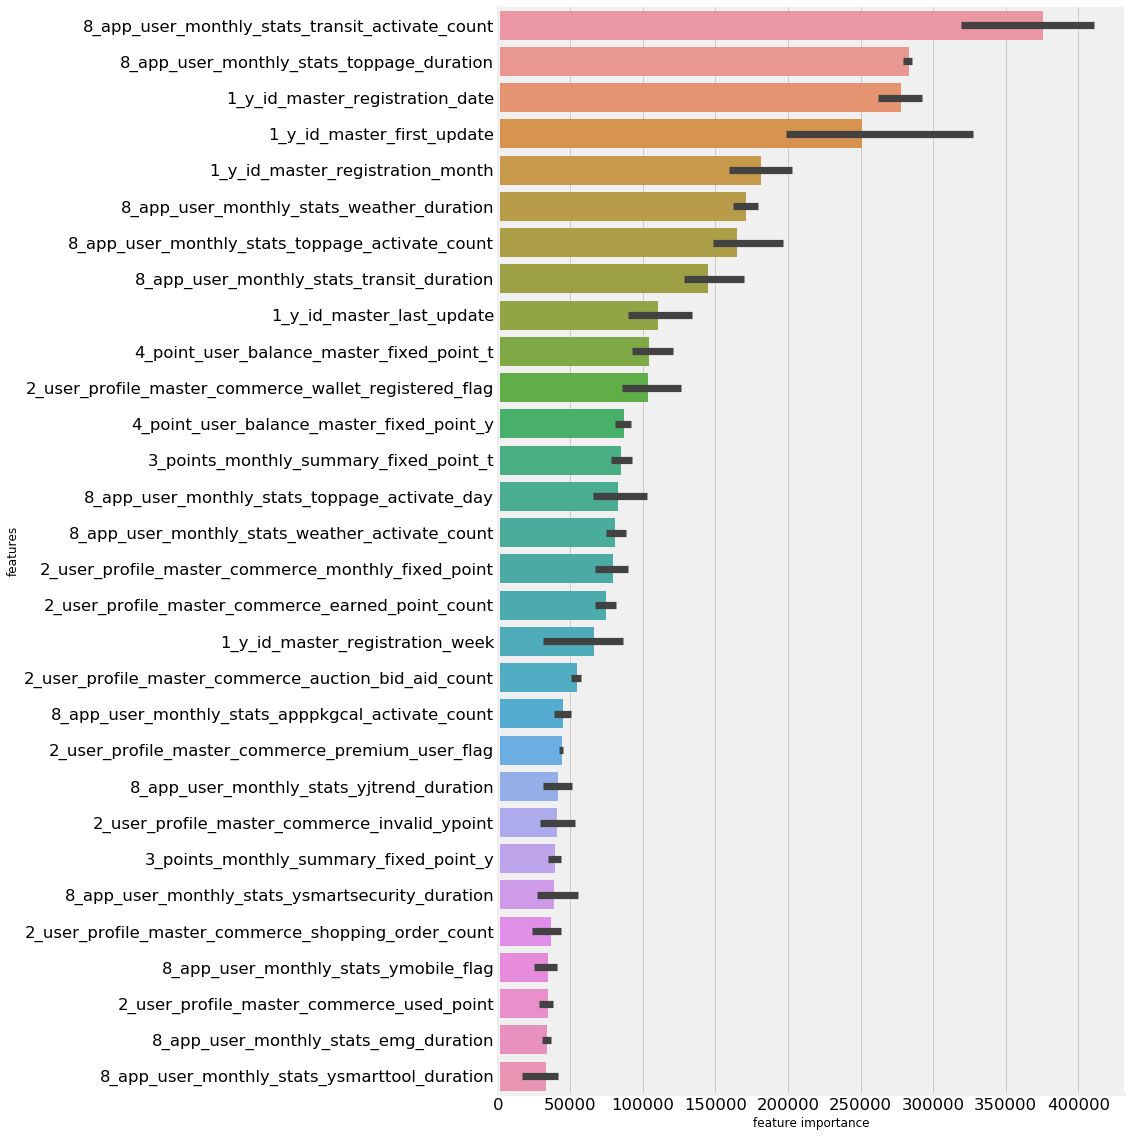

In [24]:
# plot feature importance
lgb_fi_df = lgbm_reg.plot_feature_importance(rank_range=[1,30])

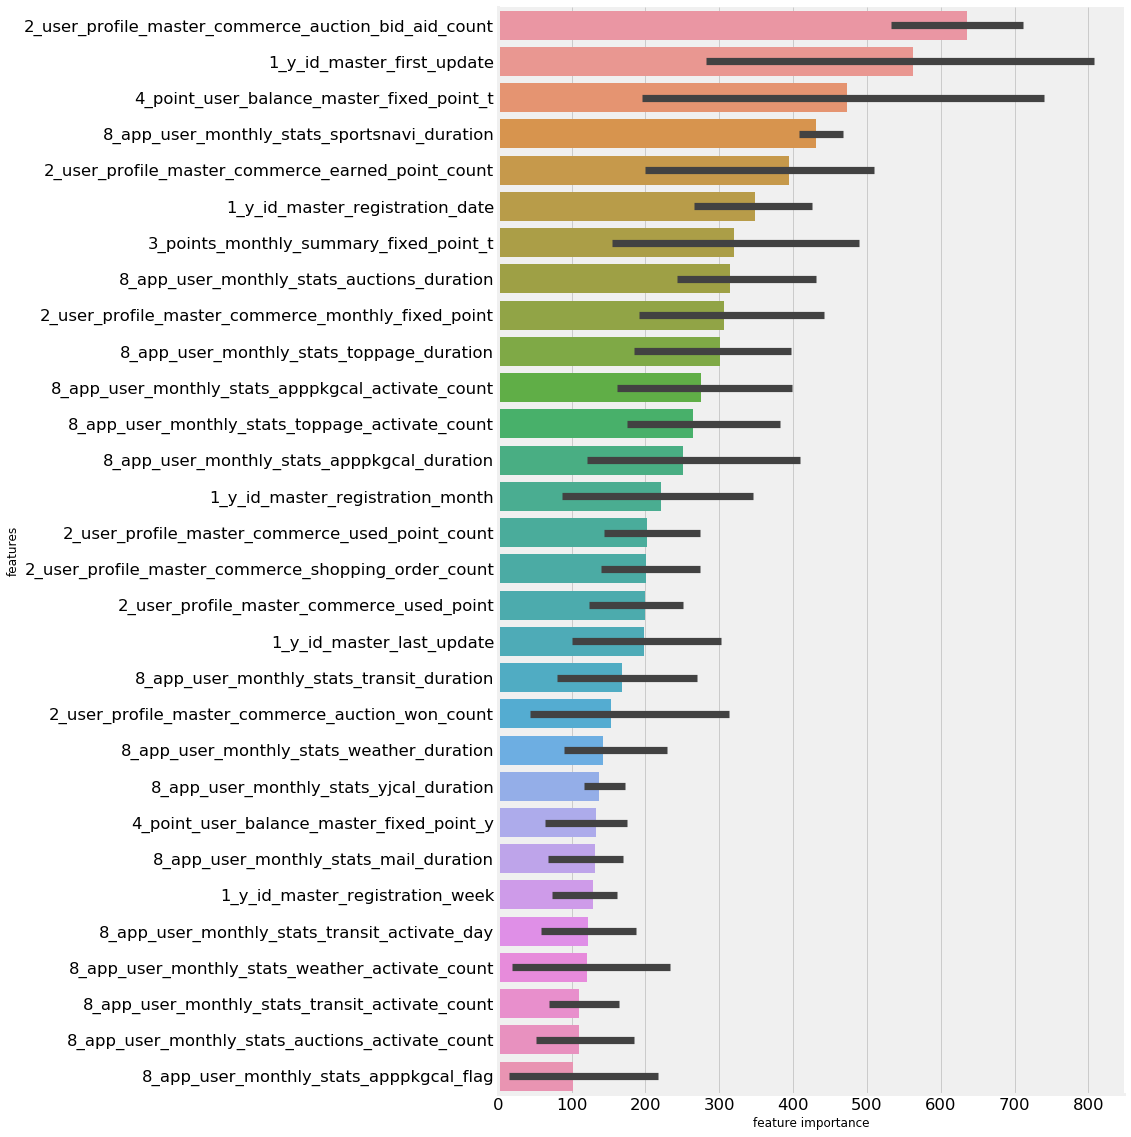

In [25]:
# plot feature importance
lgb_fi_df = lgbm_cls.plot_feature_importance(rank_range=[1,30])

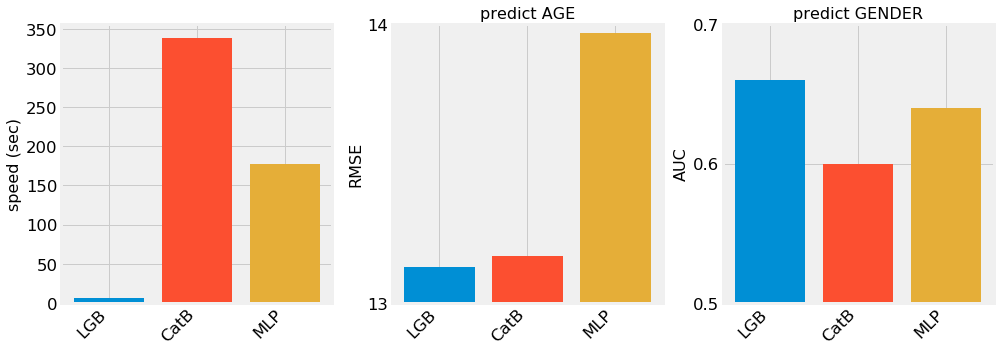

In [38]:
# compare models
speed = {"LGB": 5.73, "CatB": 338.9, "MLP": 177.5}
rmse = {"LGB": 13.13, "CatB": 13.17, "MLP": 13.97}
auc = {"LGB": 0.66, "CatB": 0.60, "MLP": 0.64}
modelnames = ["LGB", "CatB", "MLP"]
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax = ax.flatten()
for m in np.arange(3):
    # speed
    ax[0].bar(m, speed[modelnames[m]]) 
    # rmse
    ax[1].bar(m, rmse[modelnames[m]]) 
    # auc
    ax[2].bar(m, auc[modelnames[m]]) 
    # x-axis
    ax[m].set_xticks(np.arange(3))
    ax[m].set_xticklabels(modelnames, rotation=45, ha="right")
# format
ax[0].set_ylabel("speed (sec)", fontsize=16)
ax[1].set_ylabel("RMSE", fontsize=16)
ax[1].set_title("predict AGE", fontsize=16)
ax[1].set_ylim([13, 14])
ax[1].set_yticks([13, 14])
ax[2].set_ylabel("AUC", fontsize=16)
ax[2].set_title("predict GENDER", fontsize=16)
ax[2].set_ylim([0.5, 0.7])
ax[2].set_yticks([0.5, 0.6, 0.7])
plt.tight_layout()
plt.savefig(datapath +"/figs/model_compare.png", bbox_inches='tight')